# Toronto COVID - 19 Cases Project - Lin Han (Hack Instead - The One). 8.9.

## 1. Import packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style of plot
plt.style.use('ggplot')

# Data preprocessing functions
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Fit classification models
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

# Functions to evaluate classification model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score

## 2. Load and clean Toronto COVID - 19 Cases dataset (column name, variable type)

In [2]:
# Load and sort COVID19 cases csv dataset from local folder
# df = pd.read_csv('/COVID19 cases.csv')
df = pd.read_csv('C:/Users/han_l/Desktop/COVID19 cases.csv')
df = df.sort_values('_id')

# Check first 5 rows of dataframe 'df'
df.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,15339,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,15340,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,15341,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,15342,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,15343,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


In [3]:
# Check if the dataset size is sufficient to build model: df_original has 15432 observations and 18 columns
df.shape

(15432, 18)

In [4]:
# Format the column names to lowercase and remove blanks and other punctuations to underline
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df = df.rename(columns={'age_group': 'age', 'source_of_infection': 'source', 'client_gender' : 'gender', 'classification' : 'confirmed'})

# Remove features that have no impact to further analysis
df = df.drop(columns=['assigned_id'])

# Change date types
df['episode_date'] = pd.to_datetime(df['episode_date'])
df['reported_date'] = pd.to_datetime(df['reported_date'])

# Check if missing values exist and column types: age_group, neighbourhood_name, fsa have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15432 entries, 0 to 15431
Data columns (total 17 columns):
_id                       15432 non-null int64
outbreak_associated       15432 non-null object
age                       15406 non-null object
neighbourhood_name        14826 non-null object
fsa                       14872 non-null object
source                    15432 non-null object
confirmed                 15432 non-null object
episode_date              15432 non-null datetime64[ns]
reported_date             15432 non-null datetime64[ns]
gender                    15432 non-null object
outcome                   15432 non-null object
currently_hospitalized    15432 non-null object
currently_in_icu          15432 non-null object
currently_intubated       15432 non-null object
ever_hospitalized         15432 non-null object
ever_in_icu               15432 non-null object
ever_intubated            15432 non-null object
dtypes: datetime64[ns](2), int64(1), object(14)
memory usage

In [5]:
# Directly drop null values from dataset, because the percentage of null value is small
df.isnull().sum()
df = df.dropna()

In [6]:
# Calculate duration and change the data type to integer
df['duration'] = df['reported_date'] - df['episode_date']
df['duration'] = df['duration'].astype(str).str[:2]
df['duration'] = df['duration'].astype(int)

# Extract episode month from episode_date
df['episode_month'] = df['episode_date'].dt.month
df.head()

,_id,outbreak_associated,age,neighbourhood_name,fsa,source,confirmed,episode_date,reported_date,gender,outcome,currently_hospitalized,currently_in_icu,currently_intubated,ever_hospitalized,ever_in_icu,ever_intubated,duration,episode_month
0,15339,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No,1,1
1,15340,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No,2,1
2,15341,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No,16,2
3,15342,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No,9,2
4,15343,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No,6,2


## 3. Explore Toronto COVID - 19 Cases dataset (Value counts & Correlation analysis)

In [7]:
# Print value counts for categorical variables
for col in ['outbreak_associated', 'age', 'neighbourhood_name', 'fsa',
            'source', 'confirmed', 'gender', 'outcome', 'currently_hospitalized', 
            'currently_in_icu', 'currently_intubated', 'ever_hospitalized', 
            'ever_in_icu', 'ever_intubated', 'duration', 'episode_month']:
    print("* Value Count for " + col + " :")
    print(df[col].value_counts())
    print('\n')

* Value Count for outbreak_associated :
Sporadic               9293
Outbreak Associated    5514
Name: outbreak_associated, dtype: int64


* Value Count for age :
50 to 59 Years    2341
20 to 29 Years    2157
40 to 49 Years    2082
30 to 39 Years    2072
60 to 69 Years    1599
80 to 89 Years    1500
90 and older      1093
70 to 79 Years    1040
19 and younger     923
Name: age, dtype: int64


* Value Count for neighbourhood_name :
Glenfield-Jane Heights               514
West Humber-Clairville               499
Mount Olive-Silverstone-Jamestown    498
Downsview-Roding-CFB                 460
York University Heights              431
Islington-City Centre West           355
Weston                               327
Rouge                                312
Black Creek                          306
Woburn                               304
Kingsview Village-The Westway        279
Newtonbrook West                     259
Malvern                              224
South Parkdale                   

In [9]:
# Drop 5 highly correlated variables from df
df = df.drop(columns = ['_id', 'currently_intubated', 'currently_in_icu', 'ever_in_icu', 'ever_intubated'])

## 4. Create dummy variables for categorical input variables

In [10]:
# Create dummy variables
df = df.replace('Outbreak Associated', 1).replace('Sporadic', 0)

df = df.replace('CONFIRMED', 1).replace('PROBABLE', 0)

df = df.replace('Yes', 1).replace('No', 0)

In [11]:
df_onehot = pd.get_dummies(data=df, columns=['age', 'source', 'gender', 'outcome'])
df_onehot.head()

,outbreak_associated,neighbourhood_name,fsa,confirmed,episode_date,reported_date,currently_hospitalized,ever_hospitalized,duration,episode_month,...,source_Travel,source_Unknown/Missing,gender_FEMALE,gender_MALE,gender_OTHER,gender_TRANSGENDER,gender_UNKNOWN,outcome_ACTIVE,outcome_FATAL,outcome_RESOLVED
0,0,Willowdale East,M2N,1,2020-01-22,2020-01-23,0,0,1,1,...,1,0,1,0,0,0,0,0,0,1
1,0,Willowdale East,M2N,1,2020-01-21,2020-01-23,0,1,2,1,...,1,0,0,1,0,0,0,0,0,1
2,0,Parkwoods-Donalda,M3A,1,2020-02-05,2020-02-21,0,0,16,2,...,1,0,1,0,0,0,0,0,0,1
3,0,Church-Yonge Corridor,M4W,1,2020-02-16,2020-02-25,0,0,9,2,...,1,0,1,0,0,0,0,0,0,1
4,0,Church-Yonge Corridor,M4W,1,2020-02-20,2020-02-26,0,0,6,2,...,1,0,0,1,0,0,0,0,0,1


In [12]:
df_onehot.columns = df_onehot.columns.str.strip().str.lower()
df_onehot.columns

Index(['outbreak_associated', 'neighbourhood_name', 'fsa', 'confirmed',
       'episode_date', 'reported_date', 'currently_hospitalized',
       'ever_hospitalized', 'duration', 'episode_month', 'age_19 and younger',
       'age_20 to 29 years', 'age_30 to 39 years', 'age_40 to 49 years',
       'age_50 to 59 years', 'age_60 to 69 years', 'age_70 to 79 years',
       'age_80 to 89 years', 'age_90 and older', 'source_close contact',
       'source_community', 'source_healthcare', 'source_institutional',
       'source_n/a - outbreak associated', 'source_pending', 'source_travel',
       'source_unknown/missing', 'gender_female', 'gender_male',
       'gender_other', 'gender_transgender', 'gender_unknown',
       'outcome_active', 'outcome_fatal', 'outcome_resolved'],
      dtype='object')

In [13]:
# Remove features that have no impact to further predictive model building
df_new = df_onehot.drop(columns=['neighbourhood_name', 'fsa', 'episode_date', 'reported_date','source_pending', 'source_unknown/missing',
                                 'gender_other', 'gender_transgender', 'gender_unknown'])

In [14]:
df_new.shape

(14807, 26)

In [15]:
corr3 = df_new.corr()
corr3.style.background_gradient(cmap='coolwarm').set_precision(2)

,outbreak_associated,confirmed,currently_hospitalized,ever_hospitalized,duration,episode_month,age_19 and younger,age_20 to 29 years,age_30 to 39 years,age_40 to 49 years,age_50 to 59 years,age_60 to 69 years,age_70 to 79 years,age_80 to 89 years,age_90 and older,source_close contact,source_community,source_healthcare,source_institutional,source_n/a - outbreak associated,source_travel,gender_female,gender_male,outcome_active,outcome_fatal,outcome_resolved
outbreak_associated,1,0.18,-0.0039,0.036,-0.15,-0.14,-0.15,-0.19,-0.12,-0.081,-0.07,-0.022,0.097,0.32,0.32,-0.55,-0.31,-0.2,-0.11,1,-0.15,0.13,-0.16,-0.072,0.24,-0.19
confirmed,0.18,1,0.017,0.075,-0.064,0.018,-0.21,-0.07,-0.02,0.018,0.034,0.032,0.052,0.07,0.071,-0.28,0.081,0.047,0.02,0.18,-0.021,-0.0051,0.0061,-0.018,0.059,-0.045
currently_hospitalized,-0.0039,0.017,1,0.2,-0.014,0.04,-0.015,-0.019,-0.019,-0.013,0.0043,0.026,0.017,0.019,0.008,-0.024,-0.0024,0.02,0.016,-0.0039,0.011,-0.0068,0.0073,0.53,-0.021,-0.23
ever_hospitalized,0.036,0.075,0.2,1,-0.02,-0.1,-0.084,-0.13,-0.1,-0.07,-0.00018,0.087,0.18,0.14,0.037,-0.11,0.02,0.083,0.0029,0.036,0.02,-0.047,0.055,0.072,0.29,-0.3
duration,-0.15,-0.064,-0.014,-0.02,1,-0.2,-0.0037,0.027,0.022,0.029,0.028,0.019,-0.029,-0.061,-0.063,0.079,0.073,0.0041,-0.015,-0.15,0.045,-0.022,0.027,-0.052,-0.054,0.073
episode_month,-0.14,0.018,0.04,-0.1,-0.2,1,0.14,0.068,0.018,-0.0062,0.0016,-0.036,-0.041,-0.073,-0.072,0.14,0.092,-0.031,0.02,-0.14,-0.12,-0.022,0.027,0.25,-0.12,-0.011
age_19 and younger,-0.15,-0.21,-0.015,-0.084,-0.0037,0.14,1,-0.11,-0.1,-0.1,-0.11,-0.09,-0.071,-0.087,-0.073,0.23,-0.036,-0.037,-0.029,-0.15,-0.022,-0.036,0.031,0.049,-0.073,0.043
age_20 to 29 years,-0.19,-0.07,-0.019,-0.13,0.027,0.068,-0.11,1,-0.17,-0.17,-0.18,-0.14,-0.11,-0.14,-0.12,0.15,0.046,-0.0081,-0.0064,-0.19,0.0092,-0.055,0.063,0.0025,-0.12,0.1
age_30 to 39 years,-0.12,-0.02,-0.019,-0.1,0.022,0.018,-0.1,-0.17,1,-0.16,-0.17,-0.14,-0.11,-0.14,-0.11,0.047,0.048,0.042,0.007,-0.12,0.026,-0.031,0.035,-0.0038,-0.11,0.11
age_40 to 49 years,-0.081,0.018,-0.013,-0.07,0.029,-0.0062,-0.1,-0.17,-0.16,1,-0.18,-0.14,-0.11,-0.14,-0.11,0.029,0.04,0.03,0.028,-0.081,-0.00022,0.0083,-0.0065,-0.011,-0.11,0.1


In [16]:
df_new2 = df_new.drop(columns = ['outbreak_associated', 'gender_male',  'outcome_active', 'outcome_resolved'])

In [17]:
df_new2.shape

(14807, 22)

In [18]:
df_new2.columns

Index(['confirmed', 'currently_hospitalized', 'ever_hospitalized', 'duration',
       'episode_month', 'age_19 and younger', 'age_20 to 29 years',
       'age_30 to 39 years', 'age_40 to 49 years', 'age_50 to 59 years',
       'age_60 to 69 years', 'age_70 to 79 years', 'age_80 to 89 years',
       'age_90 and older', 'source_close contact', 'source_community',
       'source_healthcare', 'source_institutional',
       'source_n/a - outbreak associated', 'source_travel', 'gender_female',
       'outcome_fatal'],
      dtype='object')

In [19]:
df_new2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14807 entries, 0 to 15431
Data columns (total 22 columns):
confirmed                           14807 non-null int64
currently_hospitalized              14807 non-null int64
ever_hospitalized                   14807 non-null int64
duration                            14807 non-null int64
episode_month                       14807 non-null int64
age_19 and younger                  14807 non-null uint8
age_20 to 29 years                  14807 non-null uint8
age_30 to 39 years                  14807 non-null uint8
age_40 to 49 years                  14807 non-null uint8
age_50 to 59 years                  14807 non-null uint8
age_60 to 69 years                  14807 non-null uint8
age_70 to 79 years                  14807 non-null uint8
age_80 to 89 years                  14807 non-null uint8
age_90 and older                    14807 non-null uint8
source_close contact                14807 non-null uint8
source_community                    

## 5. Build logistic regressoin model to predict outcome_fatal  

In [20]:
# Isolate independent variables to X dataset and target variable to y dataset from df_new2
X = df_new2.drop(columns = ['outcome_fatal'])
y = df_new2['outcome_fatal']

In [21]:
# Split training and testing datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [22]:
# Fit the logistic model using another package 'statsmodels', using maximum likelihood 
# logit_model=sm.Logit(y_train.astype(float), X_train.astype(float))
logit_model=sm.Logit(y_train, X_train)
result=logit_model.fit()
print(result.summary2())

C:\Users\han_l\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\han_l\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\han_l\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


         Current function value: inf
         Iterations: 35
                                    Results: Logit
Model:                        Logit                    Pseudo R-squared:         inf   
Dependent Variable:           outcome_fatal            AIC:                      inf   
Date:                         2020-08-09 15:52         BIC:                      inf   
No. Observations:             10364                    Log-Likelihood:           -inf  
Df Model:                     20                       LL-Null:                  0.0000
Df Residuals:                 10343                    LLR p-value:              1.0000
Converged:                    0.0000                   Scale:                    1.0000
No. Iterations:               35.0000                                                  
---------------------------------------------------------------------------------------
                                  Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
--------

C:\Users\han_l\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [23]:
# p-values for most of the variables are smaller than 0.05, and drop not significant variables
X_new = X_train.drop(['currently_hospitalized', 'age_20 to 29 years', 'age_50 to 59 years', 'source_n/a - outbreak associated', 'source_institutional', 'age_19 and younger'], axis=1)

# X_new = X_train.drop(['currently_hospitalized', 'currently_intubated', 'source_close contact', 'age_80 to 89 years', 'source_travel'], axis=1)
# X_new = X_train.drop(['currently_hospitalized', 'currently_intubated', 'source_close contact', 'source_travel'], axis=1)

y_new = y_train

In [24]:
logit_model_new=sm.Logit(y_new, X_new)
result_new=logit_model_new.fit()
print(result_new.summary2())

C:\Users\han_l\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\han_l\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: inf
         Iterations 11
                           Results: Logit
Model:                  Logit              Pseudo R-squared:   inf   
Dependent Variable:     outcome_fatal      AIC:                inf   
Date:                   2020-08-09 15:52   BIC:                inf   
No. Observations:       10364              Log-Likelihood:     -inf  
Df Model:               14                 LL-Null:            0.0000
Df Residuals:           10349              LLR p-value:        1.0000
Converged:              1.0000             Scale:              1.0000
No. Iterations:         11.0000                                      
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
confirmed            -1.1483   0.2032  -5.6516 0.0000 -1.5465 -0.7501
ever_hospitalized   

C:\Users\han_l\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [25]:
# Improved Logistic Model Coefficients: 
logit_model_new.fit().params

Optimization terminated successfully.
         Current function value: inf
         Iterations 11


C:\Users\han_l\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


confirmed              -1.148266
ever_hospitalized       1.744232
duration               -0.028516
episode_month          -0.632292
age_30 to 39 years     -2.832550
age_40 to 49 years     -1.228503
age_60 to 69 years      1.296953
age_70 to 79 years      2.416201
age_80 to 89 years      2.852489
age_90 and older        3.503269
source_close contact   -1.037112
source_community       -0.822971
source_healthcare      -0.668390
source_travel          -1.430805
gender_female          -0.519401
dtype: float64

## 6. Build random forest model to find varibales importance 


In [26]:
# Fit random forest model
rf_classifier = RandomForestClassifier()  
rf_classifier.fit(X_new, y_new)  

C:\Users\han_l\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
# Drop 6 inputs from X_test to match the number of variables in X_new
X_test_new = X_test.drop(['currently_hospitalized', 'age_20 to 29 years', 'age_50 to 59 years', 'source_n/a - outbreak associated', 'source_institutional', 'age_19 and younger'], axis=1)
rf_predictions = rf_classifier.predict(X_test_new)

In [29]:
print('Accuracy:', accuracy_score(y_test, rf_predictions))
print('Precision:', precision_score(y_test, rf_predictions))
print('Recall:', recall_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Accuracy: 0.9196488858879136
Precision: 0.41304347826086957
Recall: 0.23384615384615384
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      4118
           1       0.41      0.23      0.30       325

   micro avg       0.92      0.92      0.92      4443
   macro avg       0.68      0.60      0.63      4443
weighted avg       0.90      0.92      0.91      4443



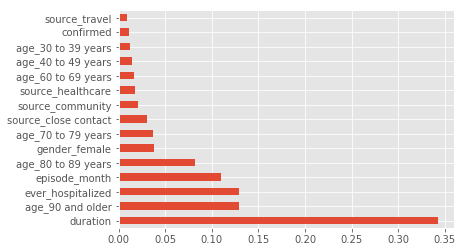

In [30]:
# Rank the importance of all 15 independent variables
feat_importances = pd.Series(rf_classifier.feature_importances_, index = X_test_new.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()